# Feature Engineering

In machine learning, a feature is an individual measurable attribute of a phenomenon being observed. The extraction of features from raw training data is called *feature engineering*. In other words, feature engineering is a process of transforming raw training data into a *representation* suitable for the application of machine learning algorithms.

This process usually requires a certain degree of domain expertise and can be divides into the following stages <sup>[[1]](#ref_1)</sup>: 
- Brainstorming on features
- Deciding what features to create
- Creating features
- Studying how the features impact model's predictive accuracy
- Iterating if necessary

In [17]:
%matplotlib inline
import os
import json
import pickle
import pyspark
from functools import reduce
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.functions import udf, mean, lit, stddev, col, expr, when
from pyspark.sql.types import DoubleType, ArrayType, ShortType, LongType, IntegerType
import pandas as pd
from collections import OrderedDict
from datetime import date
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from pyspark.storagelevel import StorageLevel

from azureml.api.schema.dataTypes import DataTypes
from azureml.api.schema.sampleDefinition import SampleDefinition
from azureml.api.realtime.services import generate_schema

In [18]:
STORAGE_ACCOUNT_SUFFIX = 'core.windows.net'

TELEMETRY_STORAGE_ACCOUNT_NAME = os.getenv('TELEMETRY_STORAGE_ACCOUNT_NAME')
TELEMETRY_STORAGE_ACCOUNT_KEY = os.getenv('TELEMETRY_STORAGE_ACCOUNT_KEY')
TELEMETRY_CONTAINER_NAME = os.getenv('TELEMETRY_CONTAINER_NAME')
STAGING_STORAGE_ACCOUNT_NAME = os.getenv('STAGING_STORAGE_ACCOUNT_NAME')
STAGING_STORAGE_ACCOUNT_KEY = os.getenv('STAGING_STORAGE_ACCOUNT_KEY')
AZUREML_NATIVE_SHARE_DIRECTORY = os.getenv('AZUREML_NATIVE_SHARE_DIRECTORY')

wasbTelemetryUrl = "wasb://{0}@{1}.blob.{2}/*/*/*/*/*/*/*".format(
            TELEMETRY_CONTAINER_NAME,
            TELEMETRY_STORAGE_ACCOUNT_NAME,
            STORAGE_ACCOUNT_SUFFIX)

sc = SparkSession.builder.getOrCreate()
hc = sc._jsc.hadoopConfiguration()
hc.set("avro.mapred.ignore.inputs.without.extension", "false")

if TELEMETRY_STORAGE_ACCOUNT_KEY:
    hc.set("fs.azure.account.key.{}.blob.core.windows.net".format(TELEMETRY_STORAGE_ACCOUNT_NAME), TELEMETRY_STORAGE_ACCOUNT_KEY)

hc.set("fs.azure.account.key.{}.blob.core.windows.net".format(STAGING_STORAGE_ACCOUNT_NAME), STAGING_STORAGE_ACCOUNT_KEY)
    
sql = SQLContext.getOrCreate(sc)

df = sql.read.format("com.databricks.spark.avro").load(wasbTelemetryUrl)

df.printSchema()

root
 |-- EnqueuedTimeUtc: string (nullable = true)
 |-- Properties: map (nullable = true)
 |    |-- key: string
 |    |-- value: string (valueContainsNull = true)
 |-- SystemProperties: map (nullable = true)
 |    |-- key: string
 |    |-- value: string (valueContainsNull = true)
 |-- Body: binary (nullable = true)



In [19]:
print('Message count: {0}'.format(df.count()))

Message count: 5460


In [20]:
sample_rate = 1024

def extract_double(c):
    return udf(lambda x: float(pickle.loads(x)[c]), DoubleType())

def extract_array(c):
    return udf(lambda x: pickle.loads(x)[c].tolist(), ArrayType(ShortType()))

def extract_amplitude_spectrum(c):
    def m(x):
        ampl = np.abs(np.fft.fft(pickle.loads(x)[c])) / sample_rate
        return ampl[:sample_rate // 2 + 1].tolist()
                      
    return udf(m, ArrayType(DoubleType()))

def extract_dominant_frequencies(index):
    def m(ff):
        freq = np.fft.fftfreq(sample_rate, d = 1/sample_rate)[:sample_rate // 2 + 1]
        return [float(f[index]) for f in sorted(list(zip(freq, ff)), key = lambda x: x[1], reverse = True)]
    
    return udf(m, ArrayType(DoubleType()))


dfa = (df
       .withColumn('machineID', df.SystemProperties['connectionDeviceId'])
       .withColumn("ambient_temperature", extract_double("ambient_temperature")(df.Body))
       .withColumn("ambient_pressure", extract_double("ambient_pressure")(df.Body))
       .withColumn("speed", extract_double("speed")(df.Body))
       .withColumn("temperature", extract_double("temperature")(df.Body))
       .withColumn("pressure", extract_double("pressure")(df.Body))
       .withColumn("vibration", extract_array("vibration")(df.Body))
       .withColumn("fft", extract_amplitude_spectrum("vibration")(df.Body))
       .drop('Properties', 'SystemProperties', 'Body'))

dfa = (dfa
       .withColumn("dominant_frequencies", extract_dominant_frequencies(0)(dfa.fft))
       .withColumn("dominant_frequencies_amplitudes", extract_dominant_frequencies(1)(dfa.fft))
       .where(dfa.speed > 0))

In [21]:
#df.unpersist()
dfa.printSchema()
input_features = ["ambient_temperature", "ambient_pressure", "speed", "temperature", "pressure", "vibration"]
input_sample = dfa.limit(5).select(input_features)

# define the input data frame
inputs = {"input_df": SampleDefinition(DataTypes.SPARK, input_sample)}

def run(input_df):
    pass

json_schema = generate_schema(run_func=run, inputs=inputs, filepath=os.path.join(AZUREML_NATIVE_SHARE_DIRECTORY, 'service_schema.json'))

root
 |-- EnqueuedTimeUtc: string (nullable = true)
 |-- machineID: string (nullable = true)
 |-- ambient_temperature: double (nullable = true)
 |-- ambient_pressure: double (nullable = true)
 |-- speed: double (nullable = true)
 |-- temperature: double (nullable = true)
 |-- pressure: double (nullable = true)
 |-- vibration: array (nullable = true)
 |    |-- element: short (containsNull = true)
 |-- fft: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- dominant_frequencies: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- dominant_frequencies_amplitudes: array (nullable = true)
 |    |-- element: double (containsNull = true)



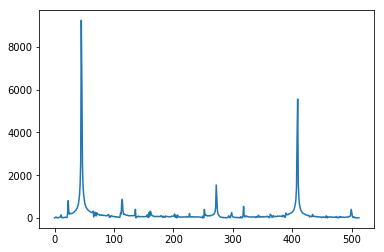

In [22]:
#dfa.limit(5).toPandas()
#print(dfa.first().speed)
fft = np.array(dfa.where(dfa.speed > 1000).first().fft)
plt.plot(fft)
plt.show()

In [23]:
k = dfa.where(dfa.machineID == 'MACHINE-000').orderBy('EnqueuedTimeUtc').take(20)
k = np.concatenate(np.array([x.vibration for x in k]))

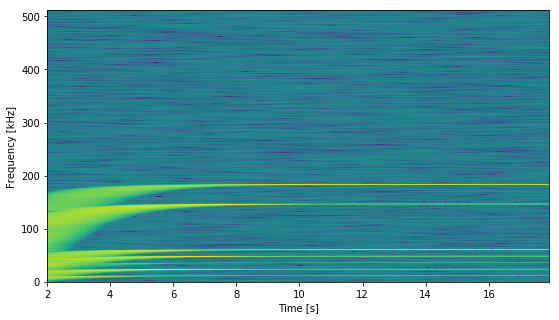

In [24]:
freqs, times, Sx = signal.spectrogram(k, fs=sample_rate, window='hanning',
                                      nperseg=4096, noverlap=4096 - 100,
                                      detrend=False, scaling='spectrum')
f, ax = plt.subplots(figsize=(9, 5))
ax.pcolormesh(times, freqs, 10 * np.log10(Sx), cmap='viridis')
ax.set_ylabel('Frequency [kHz]')
ax.set_xlabel('Time [s]')
plt.show()

In [25]:
freq = np.fft.fftfreq(sample_rate, d = 1/sample_rate)[:sample_rate // 2 + 1]
max_freq = sorted(list(zip(freq, dfa.sample(False, 0.1, seed=0).first().fft)), key = lambda x: x[1], reverse = True)[10 : ]
pdf = pd.DataFrame.from_records(max_freq)
pdf.head()

,0,1
0,269.0,462.665685
1,266.0,398.994409
2,90.0,359.171016
3,23.0,312.652908
4,110.0,290.341932


In [26]:
frequency_features = 3
dfa = reduce(lambda _df, i: _df.withColumn('f{0}'.format(i), _df.dominant_frequencies[i]), range(frequency_features), dfa)
dfa = reduce(lambda _df, i: _df.withColumn('a{0}'.format(i), _df.dominant_frequencies_amplitudes[i]), range(frequency_features), dfa)
dfa = dfa.drop('vibration', 'fft', 'dominant_frequencies', 'dominant_frequencies_amplitudes')
dfa.persist(StorageLevel.MEMORY_AND_DISK)

DataFrame[EnqueuedTimeUtc: string, machineID: string, ambient_temperature: double, ambient_pressure: double, speed: double, temperature: double, pressure: double, f0: double, f1: double, f2: double, a0: double, a1: double, a2: double]

In [27]:
dependent_features = [c for c in dfa.columns if c not in ['machineID', 'EnqueuedTimeUtc', 'speed', 'ambient_pressure', 'ambient_temperature']]
dfa = reduce(lambda _df, f: _df.withColumn('{0}_n'.format(f), col(f) / col('speed')), dependent_features, dfa)

In [28]:
wasbUrlOutput = "wasb://{0}@{1}.blob.{2}/features.parquet".format(
            'intermediate',
            STAGING_STORAGE_ACCOUNT_NAME,
            STORAGE_ACCOUNT_SUFFIX)

dfa.write.parquet(wasbUrlOutput, mode="overwrite")

dfa.limit(5).toPandas().head()

,EnqueuedTimeUtc,machineID,ambient_temperature,ambient_pressure,speed,temperature,pressure,f0,f1,f2,...,a1,a2,temperature_n,pressure_n,f0_n,f1_n,f2_n,a0_n,a1_n,a2_n
0,2018-04-09T05:21:31.5560000Z,MACHINE-009,20.0,101.0,1362.0,120.00,2724.0,45.0,46.0,409.0,...,6220.699919,5563.574244,0.088106,2.0,0.033040,0.033774,0.300294,6.794222,4.567327,4.084856
1,2018-04-09T05:21:31.6970000Z,MACHINE-008,20.0,101.0,1117.0,105.45,1675.5,223.0,93.0,37.0,...,1267.540256,1195.808706,0.094405,1.5,0.199642,0.083259,0.033124,1.450224,1.134772,1.070554
2,2018-04-09T05:21:31.8530000Z,MACHINE-006,20.0,101.0,1338.0,120.00,2676.0,268.0,89.0,267.0,...,1372.411966,1074.453509,0.089686,2.0,0.200299,0.066517,0.199552,1.204195,1.025719,0.803030
3,2018-04-09T05:21:32.4310000Z,MACHINE-004,20.0,101.0,1344.0,120.00,2688.0,269.0,112.0,45.0,...,1295.036371,1217.667110,0.089286,2.0,0.200149,0.083333,0.033482,1.481760,0.963569,0.906002
4,2018-04-09T05:21:32.4470000Z,MACHINE-003,20.0,101.0,1367.0,120.00,2734.0,273.0,91.0,114.0,...,1442.337249,1294.461786,0.087783,2.0,0.199707,0.066569,0.083394,1.176007,1.055111,0.946936


## References
<a name="ref_1"></a>1.  [Big Data: Week 3 Video 3 - Feature Engineering](https://www.youtube.com/watch?v=drUToKxEAUA). youtube.com.